This training run is done on the new dataset with 1830 airfoils, 1 mach #, 25 AoA #s, and 3 Re #s.

It runs on an MLP similar to xxxlarge of NeuralFoil: 5 layers, 512 wide.

In [1]:
%load_ext autoreload
%autoreload 2

# Define autroreload so that it doesn't cause pain in the ass when we change the functions and run this notebook

In [2]:
# Import all the models, training functions, manipulators here

# Define the relative paths, append it to the system path
import sys
from pathlib import Path
project_root = Path.cwd().resolve().parents[3]
github_root = Path.cwd().resolve().parents[2]
sys.path.append(str(project_root))
sys.path.append(str(github_root))

print(project_root)
print(github_root)

# Import shenanigans
from defs.helper_functions.training_functions import *
from defs.helper_functions.data_loaders import *
from defs.models.MLP import *

# Time, to precisely: time
import time

C:\SenkDosya\Projects\AeroML
C:\SenkDosya\Projects\AeroML\initial-project


In [3]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")  # Force CPU for testing purposes
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Figure out the data
df = pd.read_csv(rf"{str(project_root)}\airfoil_data\airfoil_dataset_8bern.csv")

df = df.drop(['N1', 'N2'], axis=1) # Remove N1 and N2 since all the airfoils are subsonic

df['Reynolds'] = df['Reynolds'] / 1000000 # Normalize the Reynolds feature, too dominant

print(df.head)

geom, cond, perf, names= get_dataset(df, loc_geometry=[1,20], loc_cond=[21,23], loc_perf_coeffs=[24,26], loc_names=0) # Get the necessary stuff for the dataset
print(df.shape); print(geom.shape); print(cond.shape); print(perf.shape); print(len(names))

ds = AirfoilDataset(geom, cond, perf, names)

del df, geom, cond, perf, names # Delete these to preserve memory

cfg_loader = {
    'n_epoch': 100,
    'n_train': 1000,
    'n_test': 17250,
    'train_batch': 1
}

dl_train, dl_val, dl_test = get_dataloaders(ds=ds, cfg_loader=cfg_loader)


<bound method NDFrame.head of         airfoil_name      Bu_0      Bu_1      Bu_2      Bu_3      Bu_4  \
0       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
1       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
2       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
3       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
4       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
...              ...       ...       ...       ...       ...       ...   
137245  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137246  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137247  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137248  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137249  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   

            Bu_5      Bu_6      Bu_7     Bu_8  ...      Bl_7      Bl_8  \
0      

In [5]:
import torch.nn as nn

# Define the model and optimizer

cfg_mlp = {
    'input_dim': 23,
    'output_dim': 3,
    'hidden_units': [512,512,512,512,512],
    'shape_activation': nn.Tanh
}

model = MLP(cfg_mlp=cfg_mlp)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

model = model.to(device)

# Define the loss_fn

loss_fn = nn.MSELoss()

In [6]:
# Show the model

from torchviz import make_dot

# Create and move inputs to device
show_tensor_1 = torch.randn(5, 20).to(device)
show_tensor_2 = torch.randn(5, 3).to(device)

# Forward pass
output = model(show_tensor_1, show_tensor_2)

make_dot(output, params=dict(model.named_parameters())).render("model_graph_mlp_3", format="png")

'model_graph_mlp_3.png'

In [7]:
# Train the model

# Define the configs of train
cfg_train = {
    'cfg_loader': cfg_loader,
    'dtype': torch.float32,
    'device': device
}

dataloaders = [dl_train, dl_val, dl_test]


collector_dict, model = train(cfg_train=cfg_train, model=model, optimizer=optimizer, loss_fn=loss_fn, dataloaders=dataloaders)

Epoch 1 | Train run 1 loss: 1.0510203838348389
Epoch 1 | Train run 2 loss: 0.14927662909030914
Epoch 1 | Train run 3 loss: 0.1602988839149475
Epoch 1 | Train run 4 loss: 0.005574303679168224
Epoch 1 | Train run 5 loss: 0.03728845715522766
Epoch 1 | Train run 6 loss: 0.4310666024684906
Epoch 1 | Train run 7 loss: 0.023155659437179565
Epoch 1 | Train run 8 loss: 0.0018118475563824177
Epoch 1 | Train run 9 loss: 0.10550635308027267
Epoch 1 | Train run 10 loss: 0.0501512847840786
Epoch 1 | Train run 11 loss: 0.01716410554945469
Epoch 1 | Train run 12 loss: 0.022809213027358055
Epoch 1 | Train run 13 loss: 0.0020811371505260468
Epoch 1 | Train run 14 loss: 0.12610915303230286
Epoch 1 | Train run 15 loss: 0.03964086249470711
Epoch 1 | Train run 16 loss: 0.028071876615285873
Epoch 1 | Train run 17 loss: 0.006162378005683422
Epoch 1 | Train run 18 loss: 0.07921215146780014
Epoch 1 | Train run 19 loss: 0.07084866613149643
Epoch 1 | Train run 20 loss: 0.0979013666510582
Epoch 1 | Train run 21 lo

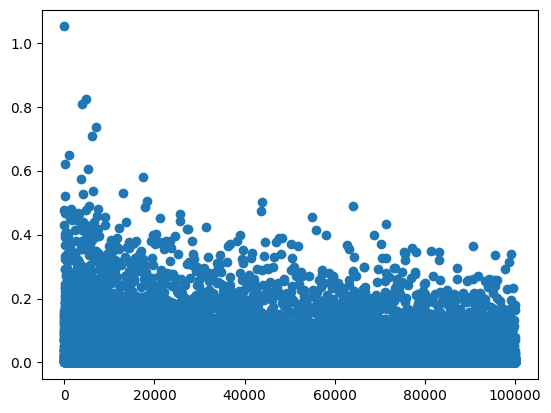

In [8]:
import numpy as np


train_losses = collector_dict['losses']['train'].numpy()
index= np.arange(100000)

import matplotlib.pyplot as plt

plt.scatter(index, train_losses, )
plt.show()

[0.05302072 0.0387038  0.02952619 0.02661378 0.03249328 0.03674628
 0.03967378 0.02358227 0.0172609  0.0281742  0.01701201 0.02311494
 0.01860284 0.01580708 0.01528109 0.01089764 0.01766891 0.01271445
 0.01692935 0.02277843 0.01863114 0.01176295 0.01381652 0.01687646
 0.00816819 0.00726942 0.00956191 0.01373526 0.01238132 0.01444937
 0.01191023 0.01438051 0.0104933  0.01087462 0.00951064 0.00879629
 0.01279265 0.01160409 0.01233657 0.00884995 0.01120605 0.02331743
 0.01034117 0.00972131 0.00887248 0.01151736 0.01570368 0.00649411
 0.00741881 0.0061826  0.00785021 0.00515654 0.00764942 0.00600958
 0.00754033 0.00816971 0.00776914 0.00414042 0.00490612 0.0082886
 0.00668621 0.00910663 0.00477263 0.00622463 0.00828187 0.0121518
 0.00590008 0.00718373 0.00922288 0.01306942 0.00684447 0.00739172
 0.0045081  0.00513273 0.00435112 0.00470142 0.01072018 0.01015699
 0.00787159 0.01047462 0.00677072 0.00583222 0.0124509  0.01349521
 0.00467443 0.00835153 0.00715547 0.00489014 0.00583453 0.004155

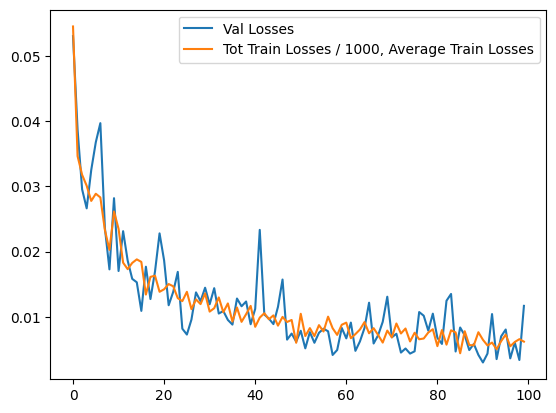

In [9]:
tot_train_losses = collector_dict['losses']['total_train'].numpy()/1000
val_losses = collector_dict['losses']['val'].numpy()

print(val_losses)
index = np.arange(100)

plt.plot(index, val_losses, label='Val Losses')
plt.plot(index, tot_train_losses, label= 'Tot Train Losses / 1000, Average Train Losses')
plt.legend()
plt.show()


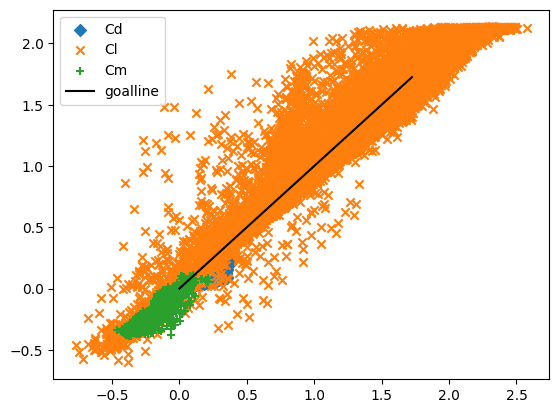

In [10]:
plt.scatter(collector_dict['actual']['test'][:,0].cpu().numpy(), collector_dict['preds']['test'][:,0].cpu().numpy(), marker='D', label= 'Cd')
plt.scatter(collector_dict['actual']['test'][:,1].cpu().numpy(), collector_dict['preds']['test'][:,1].cpu().numpy(), marker='x', label= 'Cl')
plt.scatter(collector_dict['actual']['test'][:,2].cpu().numpy(), collector_dict['preds']['test'][:,2].cpu().numpy(), marker='+', label= 'Cm')
plt.plot(np.arange(17250)/10000, np.arange(17250)/10000, color='k', label='goalline')
plt.legend()
plt.show()


From this training, one can make the following conclusions:

